In [1]:
# code to calculate the projections for maintenance and propoagation
#
#
# Version 2 Oct 17, 2024
# A. Thornton, A. Aiyyer
# NCSU Tropical and Large Scale Dynamics
#
#

In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
# Any import of metpy will activate the accessors
from metpy.units import units
import geocat.viz as gv
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [11]:
term_labels = [
        r'$\bar{u}\frac{\partial h^{\prime}}{\partial x}$',
        r'$\bar{v}\frac{\partial h^{\prime}}{\partial y}$',    
        r'$\bar{\omega}\frac{\partial h^{\prime}}{\partial p}$',
        r"$u^{\prime} \frac{\partial \bar{h}}{\partial x}$",
        r"$v^{\prime} \frac{\partial \bar{h}}{\partial y}$",
        r"${\omega}^{\prime} \frac{\partial \bar{h}}{\partial p}$",
        r"$u^{\prime} \frac{\partial h^{\prime}}{\partial x}$",
        r"$v^{\prime} \frac{\partial h^{\prime}}{\partial y}$",
        r"$\omega^{\prime} \frac{\partial h^{\prime}}{\partial p}$",
        r'SSHF',
        r'SLHF',
        r'Q',
        r'Res'
    ]

In [12]:
def var_list(EnerVar):
    variables = [
        'ubar_'+EnerVar+'p_dx_vint',
        'vbar_'+EnerVar+'p_dy_vint',
        'wbar_'+EnerVar+'p_dp_vint',
        'up_'+EnerVar+'bar_dx_vint',
        'vp_' + EnerVar+'bar_dy_vint', 'wp_' + EnerVar+'bar_dp_vint',
        'up_'+EnerVar+'p_dx_vint',
        'vp_' + EnerVar+'p_dy_vint', 'wp_' + EnerVar+'p_dp_vint',
        'sshf', 'slhf',
        'Q_prime']
    return variables
def name_list(EnerVar):
    varNames =  [
        'ubar_'+ EnerVar+'p_dx_vint_prime', 
        'vbar_'+ EnerVar+'p_dy_vint_prime', 
        'wbar_'+ EnerVar+'p_dp_vint_prime',
        'up_' + EnerVar+'bar_dx_vint_prime', 
        'vp_' + EnerVar+'bar_dy_vint_prime', 'wp_' + EnerVar+'bar_dp_vint_prime',
        'up_' + EnerVar+'p_dx_vint_prime', 
        'vp_' + EnerVar+'p_dy_vint_prime', 'wp_' + EnerVar+'p_dp_vint_prime',
        'SSHF_prime', 'SLHF_prime', 
        'Q_prime']
    return varNames

In [13]:
def plotting():
    # Negative bars in one color, positive in another
    def set_bar_color(value):
        if value >= 0:
            return  '///'  #None  
        else:
            return '///'  

    # Plot the total bar
    for i in range(len(term_labels)):
        result = h_proj[i]
        hatch = set_bar_color(result.all())
        ax[iplot,j].bar(i, result, color='white', edgecolor='black', alpha=0.7, hatch=hatch, capstyle='projecting', label='MSE')
    
    # Create a figure and axis object for plotting
    bar_width = 0.34  
    category_positions = range(len(term_labels))
    
    #Plot Bar 1 on the left half of the total bar
    ax[iplot,j].bar([pos - bar_width / 2 for pos in category_positions], s_proj, color='gold', width=bar_width, label='DSE', alpha=0.6)#, edgecolor='black')
    
    # Plot Bar 2 on the right half of the total bar
    ax[iplot,j].bar([pos + bar_width / 2 for pos in category_positions], q_proj, color='lightskyblue', width=bar_width, label='Moisture', alpha=0.7)#, edgecolor='black')
    
    
    # Set x-ticks and labels for ocean terms
    ax[iplot,j].set_xticks(np.arange(len(term_labels)))
    ax[iplot,j].set_xticklabels(term_labels, rotation='horizontal', fontsize=15)
    Rtitle = 'Lat=' + str(latRef) + ' Lon=' + str(lonRef) + ', Level = ' +str(level)
    # Use geocat.viz.util convenience function to set titles and labels
    gv.set_titles_and_labels(ax[iplot,j],
                         righttitle=Rtitle,                         
                         righttitlefontsize=15)  
    
    # Get the handles and labels from the legend
    handles, labels = ax[iplot,j].get_legend_handles_labels()
    
    # Remove duplicates from the handles and labels
    handles = handles[-3:]  # Keep only the first handle (MSE)
    labels = labels[-3:]  # Keep only the first label (MSE)
    
    # Update the legend with the filtered handles and labels
    ax[iplot,j].legend(handles, labels)
    ax[iplot,j].set_ylim(-25, 25)    
    ax[iplot,j].tick_params(axis='y', labelsize=15)
    
    plt.tight_layout()
    ax[iplot,j].hlines(y=0, xmin=-0.4, xmax=12.4, color='black', linewidth=0.8)

In [14]:
path_composite = '/glade/derecho/scratch/aiyyer/data/composites/refV'
plotsdir = '/glade/u/home/athornton/plots/projections/'

In [15]:
itracks = [5, 3, 1]

# Selections:
levels = [850,600]
stormTracks = ['N', 'N', 'O'],['S', 'O', 'O']
Ltitle = ['Northern Track','Southern Track']

deltaLon = 5
deltaLat = 5

label = ['(a) ','(b) ','(c) '], ['(d) ','(e) ','(f) ']

In [24]:
def lat_lon_bounds(stormTrack, lonRef, latRef, deltaLon):
    
    if (stormTrack == 'N'):
        latS = 17.
        latN = 22.
    if (stormTrack == 'S' ):
        latS = 0. #5.
        latN = 17. #25.
    if (stormTrack == 'O' ):
        latS = 5.
        latN = 20.

    lonW = lonRef - deltaLon
    lonE = lonRef + deltaLon
    return latS, latN, lonW, lonE

In [25]:
def mse_projection(mse, mse_tend, EnerVar):
    variables = var_list(EnerVar)
    varNames = name_list(EnerVar)
    h_proj = []
    firstTime = True
    for variab, varNam in zip(variables, varNames):
        fileName = path_composite + str(level) + '/' + variab + '_Lag_Composite_RefV_' +  \
        str(level) + 'hPa' + '_track_point_' + str(itrack) + '.nc'    
        df = xr.open_dataset(fileName)
        lonRef = df.Reflon.values
        latRef = df.Reflat.values
        latS,latN,lonW,lonE = lat_lon_bounds(stormTrack,lonRef,latRef,deltaLon)
        forc = df[varNam].sel(latitude=slice(latN, latS),
                              longitude=slice(lonW, lonE),
                              Lag=slice(-24,24)).metpy.quantify()

        numer = xr.dot(forc, mse, dims=['latitude', 'longitude', 'Lag'], optimize=True)
        frac = (numer/denom)
        print(variab, "numer = ", numer.values , "  Projection = ", frac.values)
        h_proj.append(frac.values)

        if (firstTime):
            sum_forc = forc
            firstTime=False
        else:
            sum_forc = forc + sum_forc  # Add to previous value 

    residual = mse_tend - sum_forc
    numer = xr.dot(residual, mse, dims=['latitude', 'longitude', 'Lag'], optimize=True)
    frac = (numer / denom)
    print('residual = ', numer.values, " Projection = ", frac.values)
    # add the residual to the proj array
    h_proj.append(frac.values)
    return h_proj

In [26]:
# mse
def mse_func():
    variab = 'mse_vint'
    varNam = 'mse_vint_prime'  
    fileName = path_composite + str(level) + '/' + variab + '_Lag_Composite_RefV_' +  \
    str(level) + 'hPa' + '_track_point_' + str(itrack) + '.nc'
    #print(fileName)
    df = xr.open_dataset(fileName)
    lonRef = df.Reflon.values
    latRef = df.Reflat.values
    latS,latN,lonW,lonE = lat_lon_bounds(stormTrack,lonRef,latRef,deltaLon)
    mse = df[varNam].sel(latitude=slice(latN, latS), longitude=slice(lonW, lonE), Lag=slice(-24,24)).metpy.quantify()    
 
    variab = 'hp_vint_tend'
    varNam = 'hp_vint_tend_prime'  
    fileName = path_composite + str(level) + '/' + variab + '_Lag_Composite_RefV_' +  \
    str(level) + 'hPa' + '_track_point_' + str(itrack) + '.nc'
    print(fileName)
    df = xr.open_dataset(fileName)
    lonRef = df.Reflon.values
    latRef = df.Reflat.values
    mse_tend = df[varNam].sel(latitude=slice(latN, latS), longitude=slice(lonW, lonE), Lag=slice(-24,24)).metpy.quantify()
    print('ref lat/lon=', latRef, lonRef)

    mse.attrs['lonRef'] = lonRef
    mse.attrs['latRef'] = latRef
    return mse, mse_tend

/glade/derecho/scratch/aiyyer/data/composites/refV850/hp_vint_tend_Lag_Composite_RefV_850hPa_track_point_5.nc
ref lat/lon= 21.5 14.0
ubar_hp_dx_vint numer =  -5743712937.101257   Projection =  -5.683744450491422e-08
vbar_hp_dy_vint numer =  -80717323887.74669   Projection =  -7.987457707749489e-07
wbar_hp_dp_vint numer =  49568537772.947136   Projection =  4.905100665217941e-07
up_hbar_dx_vint numer =  26972089337.987217   Projection =  2.6690481361401834e-07
vp_hbar_dy_vint numer =  541840473195.93506   Projection =  5.361832696557603e-06
wp_hbar_dp_vint numer =  -117826714097.46878   Projection =  -1.1659651861172417e-06
up_hp_dx_vint numer =  14489331598.966747   Projection =  1.4338052574841873e-07
vp_hp_dy_vint numer =  -203326428925.41425   Projection =  -2.0120355503461133e-06
wp_hp_dp_vint numer =  -29849214113.083447   Projection =  -2.953756688829057e-07
sshf numer =  -14177363347.85198   Projection =  -1.4029341496238083e-07
slhf numer =  -6100597837.081163   Projection =  -

/glade/derecho/scratch/athornton/tmp/ipykernel_39902/3597814505.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV850/hp_vint_tend_Lag_Composite_RefV_850hPa_track_point_3.nc
ref lat/lon= 21.5 -11.0
ubar_hp_dx_vint numer =  -116279992396.04933   Projection =  -6.821609223015235e-07
vbar_hp_dy_vint numer =  -46644991764.06858   Projection =  -2.736445879197105e-07
wbar_hp_dp_vint numer =  154361261901.0914   Projection =  9.055661134499104e-07
up_hbar_dx_vint numer =  17053692923.71833   Projection =  1.0004612705741723e-07
vp_hbar_dy_vint numer =  1684132721731.4717   Projection =  9.880027570190558e-06
wp_hbar_dp_vint numer =  -661197640232.4847   Projection =  -3.878940674061371e-06
up_hp_dx_vint numer =  -37589335052.55006   Projection =  -2.2051923929279283e-07
vp_hp_dy_vint numer =  -910103079940.1698   Projection =  -5.339153740970976e-06
wp_hp_dp_vint numer =  41621682182.4156   Projection =  2.44175154471907e-07
sshf numer =  -43802560630.80326   Projection =  -2.5696935941743627e-07
slhf numer =  -20859088804.583607   Projection =  -1.22370

/glade/derecho/scratch/athornton/tmp/ipykernel_39902/3597814505.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV850/hp_vint_tend_Lag_Composite_RefV_850hPa_track_point_1.nc
ref lat/lon= 12.0 -34.0
ubar_hp_dx_vint numer =  -755137057369.6752   Projection =  -2.042080906646384e-06
vbar_hp_dy_vint numer =  78424644757.18092   Projection =  2.1208000336654632e-07
wbar_hp_dp_vint numer =  -105661687228.87256   Projection =  -2.8573583026861477e-07
up_hbar_dx_vint numer =  -191177497316.349   Projection =  -5.169921317462737e-07
vp_hbar_dy_vint numer =  2867615050966.695   Projection =  7.754753770909358e-06
wp_hbar_dp_vint numer =  -1076958753429.1799   Projection =  -2.9123678756858954e-06
up_hp_dx_vint numer =  -608056815668.3748   Projection =  -1.6443388671160348e-06
vp_hp_dy_vint numer =  -1708357763313.4346   Projection =  -4.6198299184722045e-06
wp_hp_dp_vint numer =  638111838563.4895   Projection =  1.7256152232476183e-06
sshf numer =  -33752179648.536285   Projection =  -9.127439972030498e-08
slhf numer =  73244930236.57993   Projection =  1.

/glade/derecho/scratch/athornton/tmp/ipykernel_39902/3597814505.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV600/hp_vint_tend_Lag_Composite_RefV_600hPa_track_point_5.nc
ref lat/lon= 8 14.0
ubar_hp_dx_vint numer =  53967942563.87278   Projection =  1.0401119065383023e-06
vbar_hp_dy_vint numer =  -60855490520.90734   Projection =  -1.1728540548699086e-06
wbar_hp_dp_vint numer =  18857939460.846363   Projection =  3.634447865562147e-07
up_hbar_dx_vint numer =  -3531157661.1148024   Projection =  -6.805520004477797e-08
vp_hbar_dy_vint numer =  492615727436.41296   Projection =  9.494071093190694e-06
wp_hbar_dp_vint numer =  -246869421613.92108   Projection =  -4.757858324448181e-06
up_hp_dx_vint numer =  -51389255006.11074   Projection =  -9.904134465887482e-07
vp_hp_dy_vint numer =  -282039752813.04083   Projection =  -5.435688134132052e-06
wp_hp_dp_vint numer =  104433143666.7102   Projection =  2.0127162720056005e-06
sshf numer =  26627191999.00234   Projection =  5.131798271365548e-07
slhf numer =  42477152207.9523   Projection =  8.1865251236

/glade/derecho/scratch/athornton/tmp/ipykernel_39902/3597814505.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV600/hp_vint_tend_Lag_Composite_RefV_600hPa_track_point_3.nc
ref lat/lon= 12.0 -11.0
ubar_hp_dx_vint numer =  -128212506730.87198   Projection =  -9.278073457910398e-07
vbar_hp_dy_vint numer =  -6764783325.420268   Projection =  -4.895322478316681e-08
wbar_hp_dp_vint numer =  42204878105.08145   Projection =  3.054147909010598e-07
up_hbar_dx_vint numer =  111061748852.84601   Projection =  8.036962153650681e-07
vp_hbar_dy_vint numer =  990876481759.8206   Projection =  7.170458654849594e-06
wp_hbar_dp_vint numer =  -643571199005.06   Projection =  -4.657190637648341e-06
up_hp_dx_vint numer =  -238159069354.686   Projection =  -1.7234335373994337e-06
vp_hp_dy_vint numer =  -519478127735.98175   Projection =  -3.7591935075641593e-06
wp_hp_dp_vint numer =  224404932245.69495   Projection =  1.6239019880200447e-06
sshf numer =  40609900587.63564   Projection =  2.9387276668836695e-07
slhf numer =  72138035911.5259   Projection =  5.220255132

/glade/derecho/scratch/athornton/tmp/ipykernel_39902/3597814505.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


/glade/derecho/scratch/aiyyer/data/composites/refV600/hp_vint_tend_Lag_Composite_RefV_600hPa_track_point_1.nc
ref lat/lon= 12.0 -34.0
ubar_hp_dx_vint numer =  -326386498968.8145   Projection =  -9.542419886554675e-07
vbar_hp_dy_vint numer =  105548665611.18448   Projection =  3.0858803562941214e-07
wbar_hp_dp_vint numer =  -130017103468.36537   Projection =  -3.8012534147354864e-07
up_hbar_dx_vint numer =  -152339323766.448   Projection =  -4.453878445358553e-07
vp_hbar_dy_vint numer =  2719851023444.368   Projection =  7.951909952335825e-06
wp_hbar_dp_vint numer =  -1032044797464.8063   Projection =  -3.017344415365794e-06
up_hp_dx_vint numer =  -894358159241.8181   Projection =  -2.6147959892382052e-06
vp_hp_dy_vint numer =  -1654627437508.3074   Projection =  -4.837562158484653e-06
wp_hp_dp_vint numer =  613147050575.7535   Projection =  1.792631321234723e-06
sshf numer =  -24785061543.044174   Projection =  -7.246300472141287e-08
slhf numer =  62350315777.79325   Projection =  1.82

/glade/derecho/scratch/athornton/tmp/ipykernel_39902/3597814505.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:394: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


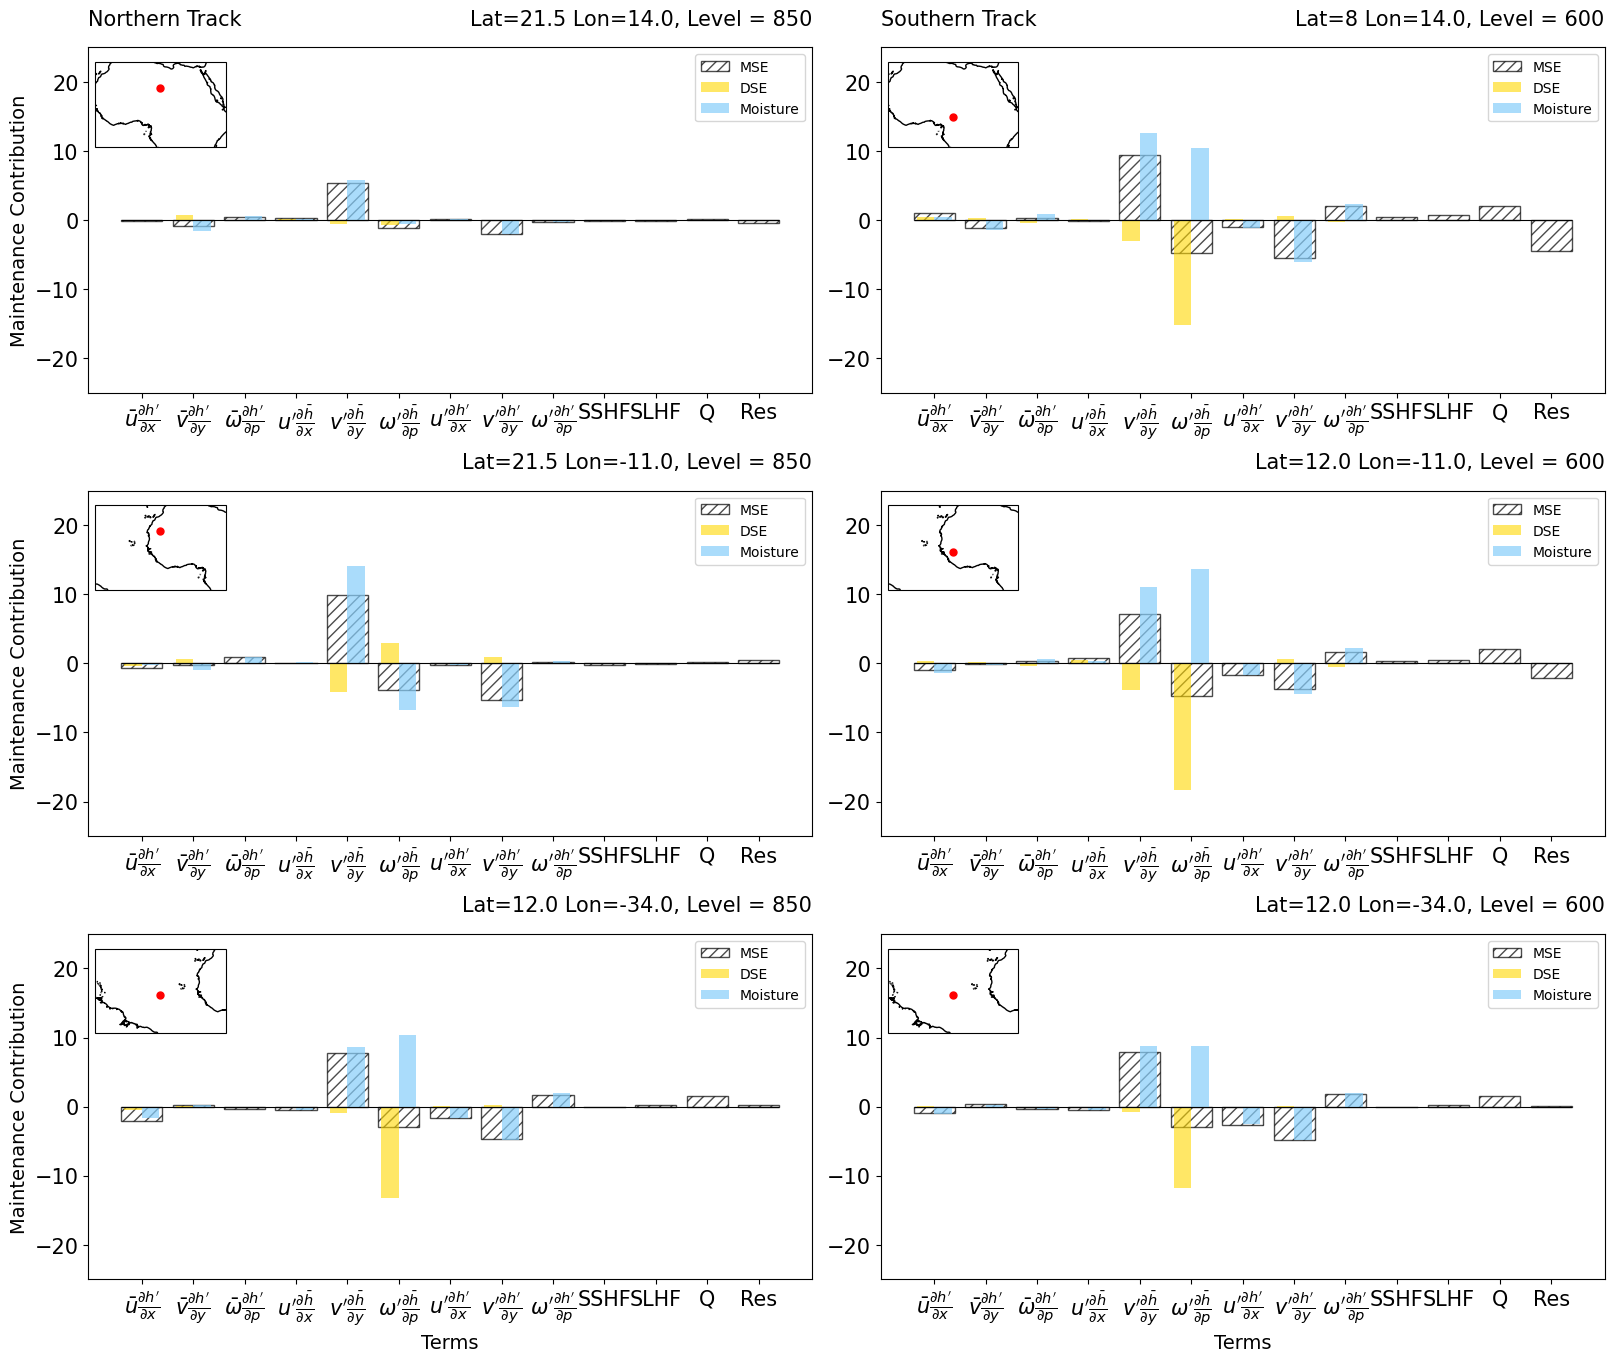

In [27]:
fig, ax = plt.subplots(3,2,constrained_layout=True)
# Set figure size (width, height) in inches
fig.set_size_inches((16,14))
plt.rcParams['savefig.dpi'] = 255

for j in range(0,2):
    for iplot in range(0,3):
        level = levels[j]
        itrack = itracks[iplot]
        stormTrack = stormTracks[j][iplot]
        mse, mse_tend = mse_func()
        denom = xr.dot(mse,mse, dims=['latitude','longitude','Lag'], optimize=True)
        h_proj = mse_projection(mse, mse_tend, 'h')
        s_proj = mse_projection(mse, mse_tend, 's')
        q_proj = mse_projection(mse, mse_tend, 'q')
    
    
        #print( iplot, denom.values)
        # scale for plotting
        h_proj = [hh*1.e6 for hh in h_proj]
        q_proj = [hh*1.e6 for hh in q_proj]
        s_proj = [hh*1.e6 for hh in s_proj]
        # zero out fluxes and residual since they do not belong here 
        s_proj[9:13] = [0., 0., 0., 0.]
        q_proj[9:13] = [0., 0., 0., 0.]
    
        lonRef = mse.attrs['lonRef'] 
        latRef = mse.attrs['latRef'] 
        
        plotting()
        # Add the map subplot to the existing figure
        inset_ax = inset_axes(ax[iplot,j],
                        width="18%", # width = 18% of parent_bbox
                        height=1.0, # height : 1 inch
                        loc=2, #bbox_transform=ax.transAxes,
                        axes_class=cartopy.mpl.geoaxes.GeoAxes,
                        axes_kwargs=dict(map_projection=ccrs.PlateCarree()))
        minlon = lonRef - 30.
        maxlon = lonRef + 30.
        minlat = -5.
        maxlat = 30.
    
        #Set the extent or specific region for the inset map
        inset_ax.set_extent([minlon, maxlon, minlat, maxlat])  
    
        #Add coastlines and other features to the inset map
        inset_ax.add_feature(cfeature.COASTLINE, zorder=1)
        inset_ax.plot(lonRef, latRef, marker='o', markersize=5, color='red', transform=ccrs.PlateCarree())

gv.set_titles_and_labels(ax[0,0],
                         lefttitle=Ltitle[0],
                         lefttitlefontsize=15)
gv.set_titles_and_labels(ax[0,1],
                         lefttitle=Ltitle[1],
                         lefttitlefontsize=15)

ax[2,0].set_xlabel('Terms', fontsize=14)
ax[2,1].set_xlabel('Terms', fontsize=14)

ax[0,0].set_ylabel('Maintenance Contribution', fontsize=14)
ax[1,0].set_ylabel('Maintenance Contribution', fontsize=14)
ax[2,0].set_ylabel('Maintenance Contribution', fontsize=14)


plt.subplots_adjust(top=0.925)  # Adjust 'top' to increase space
#plt.suptitle('Relative Contribution to Maintenance', weight='bold', fontsize = 20)
#plt.savefig('maintenance_projections.png', bbox_inches='tight')